In [3]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-19,24640.027344,25093.054688,24327.642578,24327.642578,24327.642578,25555105670
2023-02-20,24336.623047,25020.458984,23927.910156,24829.148438,24829.148438,28987376573
2023-02-21,24833.048828,25126.851562,24200.363281,24436.353516,24436.353516,31252098714


In [8]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2981 entries, 2014-12-25 to 2023-02-22
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2981 non-null   float64
 1   High       2981 non-null   float64
 2   Low        2981 non-null   float64
 3   Adj Close  2981 non-null   float64
 4   Volume     2981 non-null   int64  
 5   RSI        2981 non-null   float64
 6   EMA_short  2981 non-null   float64
 7   EMA_long   2981 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 209.6 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,17821046406,48.538550,22317.339823,20103.186881
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,23918742607,48.750732,22268.840941,20136.947568
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,26792596581,53.052268,22264.266059,20178.212065
2023-02-15,22220.585938,24307.841797,22082.769531,24307.841797,32483312909,67.728410,22458.892320,20259.986911
2023-02-16,24307.349609,25134.117188,23602.523438,23623.474609,39316664596,61.025952,22569.804919,20326.590628
2023-02-17,23621.283203,24924.041016,23460.755859,24565.601562,41358451255,65.990173,22759.880790,20410.531439
2023-02-18,24565.296875,24798.835938,24468.373047,24641.277344,19625427158,66.358943,22939.061414,20494.308585
2023-02-19,24640.027344,25093.054688,24327.642578,24327.642578,25555105670,63.310636,23071.307239,20570.216189
2023-02-20,24336.623047,25020.458984,23927.910156,24829.148438,28987376573,65.987423,23238.720687,20654.551481


In [14]:
from datetime import datetime

def date_parser(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    return date_obj.strftime('%m-%d-%Y')


In [24]:
data_csv = pd.read_csv('btc-2015-2022.csv', parse_dates=['Date'], date_parser=date_parser)
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2823 entries, 2015-04-09 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2823 non-null   float64
 1   High       2823 non-null   float64
 2   Low        2823 non-null   float64
 3   Adj Close  2823 non-null   float64
 4   Volume     2823 non-null   float64
 5   RSI        2823 non-null   float64
 6   EMA_short  2823 non-null   float64
 7   EMA_long   2823 non-null   float64
dtypes: float64(8)
memory usage: 198.5 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2022-12-21,16904.52734,16916.80078,16755.91211,16817.53516,1.488295e+10,46.354643,16990.20823,18631.71627
2022-12-22,16818.38086,16866.67383,16592.40820,16830.34180,1.644157e+10,46.537922,16974.98285,18596.04549
2022-12-23,16829.64453,16905.21875,16794.45898,16796.95313,1.532927e+10,46.097985,16958.02764,18560.41990
2022-12-24,16796.97656,16864.70313,16793.52734,16847.75586,9.744636e+09,46.916068,16947.52557,18526.50576
2022-12-25,16847.50586,16860.55469,16755.25391,16841.98633,1.165638e+10,46.829585,16937.47421,18493.14894
2022-12-26,16842.25000,16920.12305,16812.36914,16919.80469,1.188696e+10,48.209222,16935.79140,18461.99361
2022-12-27,16919.29102,16959.84570,16642.07227,16717.17383,1.574858e+10,44.954914,16914.97068,18427.44272
2022-12-28,16716.40039,16768.16992,16497.55664,16552.57227,1.700571e+10,42.460302,16880.45654,18390.31658
2022-12-29,16552.32227,16651.75586,16508.68359,16642.34180,1.447224e+10,44.267447,16857.77895,18355.70321


In [86]:
# Normalizing/Scaling the Data
scaler = MinMaxScaler()
data_csv = pd.DataFrame(scaler.fit_transform(data_csv), columns=data_csv.columns, index=data_csv.index)
data_csv

,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2015-04-09,0.000515,0.000325,0.000602,0.000493,0.000031,0.373715,0.000379,0.000264
2015-04-10,0.000499,0.000290,0.000502,0.000380,0.000052,0.324967,0.000352,0.000259
2015-04-11,0.000385,0.000229,0.000523,0.000387,0.000016,0.329864,0.000328,0.000253
2015-04-12,0.000393,0.000203,0.000513,0.000381,0.000005,0.327217,0.000307,0.000248
2015-04-13,0.000384,0.000191,0.000339,0.000209,0.000059,0.257933,0.000269,0.000238
...,...,...,...,...,...,...,...,...
2022-12-26,0.246989,0.243508,0.251015,0.248073,0.033840,0.451965,0.265264,0.332945
2022-12-27,0.248133,0.244087,0.248442,0.245065,0.044843,0.412828,0.264934,0.332314
2022-12-28,0.245120,0.241291,0.246258,0.242621,0.048425,0.382827,0.264385,0.331636


In [25]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(2823, 8)

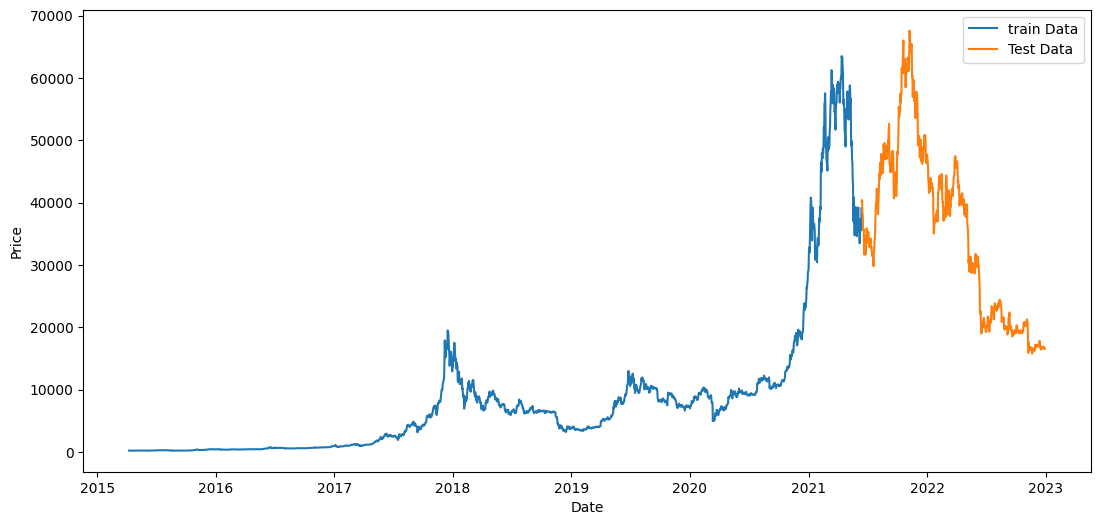

In [26]:
plt.figure(figsize=(13, 6))
plt.plot(train_df['Adj Close'], label='train Data')
plt.plot(test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [27]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()


In [28]:
print(train_df.info())
print(test_df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2258 entries, 2015-04-09 to 2021-06-13
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2258 non-null   float64
 1   High       2258 non-null   float64
 2   Low        2258 non-null   float64
 3   Adj Close  2258 non-null   float64
 4   Volume     2258 non-null   float64
 5   RSI        2258 non-null   float64
 6   EMA_short  2258 non-null   float64
 7   EMA_long   2258 non-null   float64
dtypes: float64(8)
memory usage: 158.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 565 entries, 2021-06-14 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       565 non-null    float64
 1   High       565 non-null    float64
 2   Low        565 non-null    float64
 3   Adj Close  565 non-null    float64
 4   Volume     565 non-null    float64
 5   RSI        565 non-nu

In [29]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (2258, 7)
y_train (2258,)
X_test (565, 7)
y_test (565,)


In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print("x_train", X_train.shape)
print("X_test", X_test.shape)

x_train (2258, 7)
X_test (565, 7)


In [31]:
num_samples = X_train.shape[0] - 15 - 10  # number of samples with 15 input days and 10 output days
X_train_new = np.zeros((num_samples, 15, X_train.shape[-1]))  # initialize new input array
y_train_new = np.zeros((num_samples, 10))  # initialize new output array

for i in range(num_samples):
    X_train_new[i] = X_train[i:i+15]  # input is 15 consecutive days
    y_train_new[i] = y_train[i+15:i+15+10]  # output is 10 consecutive days, starting from the 16th day

# reshape to fit the model input shape
X_train_new = X_train_new.reshape(-1, 15, X_train.shape[-1])
y_train_new = y_train_new.reshape(-1, 10)

num_samples_test = X_test.shape[0] - 15 - 10  # number of samples with 15 input days and 10 output days
X_test_new = np.zeros((num_samples_test, 15, X_test.shape[-1]))  # initialize new input array
y_test_new = np.zeros((num_samples_test, 10))  # initialize new output array

for i in range(num_samples_test):
    X_test_new[i] = X_test[i:i+15]  # input is 15 consecutive days
    y_test_new[i] = y_test[i+15:i+15+10]  # output is 10 consecutive days, starting from the 16th day

# reshape to fit the model input shape
X_test_new = X_test_new.reshape(-1, 15, X_test.shape[-1])
y_test_new = y_test_new.reshape(-1, 10)

print("x_train_new", X_train_new.shape)
print("y_train_new", y_train_new.shape)
print("X_test_new", X_test_new.shape)
print("y_test_new", y_test_new.shape)


x_train_new (2233, 15, 7)
y_train_new (2233, 10)
X_test_new (540, 15, 7)
y_test_new (540, 10)


In [33]:

y_train_new = scaler.fit_transform(y_train_new)

y_test_new = scaler.fit_transform(y_test_new)

print("x_train_new", X_train_new.shape)
print("y_train_new", y_train_new.shape)
print("X_test_new", X_test_new.shape)
print("y_test_new", y_test_new.shape)

x_train_new (2233, 15, 7)
y_train_new (2233, 10)
X_test_new (540, 15, 7)
y_test_new (540, 10)


In [70]:
# Truncate data to nearest multiple of 30
num_samples = X_train.shape[0] - X_train.shape[0] % 15
X_train = X_train[:num_samples]
num_samples = X_test.shape[0] - X_test.shape[0] % 15
X_test = X_test[:num_samples]

X_train = X_train.reshape(-1, 15, X_train.shape[-1])
X_test = X_test.reshape(-1, 15, X_test.shape[-1])



print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (150, 15, 7)
y_train (2258,)
X_test (37, 15, 7)
y_test (565,)


In [84]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [75]:
"""num_samples = X_train.shape[0] * X_train.shape[1] // y_train.shape[1]
y_train = y_train[:num_samples]
y_train = y_train.reshape(-1, y_train.shape[-1])"""



#pad_size_train = 10 - y_train.shape[0] % 10
#y_train = np.concatenate([y_train, np.zeros((pad_size_train, 1))])
y_train = y_train.reshape(X_train.shape[0], 10)



# Check the shape of y_train and y_test
print('y_train', y_train.shape)
print('y_test', y_test.shape)



ValueError: cannot reshape array of size 2260 into shape (150,10)

In [83]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (2258, 1, 7)
y_train (2258,)
X_test (565, 1, 7)
Y_test (565,)
X_train.shape[1] 1
X_train.shape[2] 7


In [34]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=( X_train_new.shape[1], X_train_new.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           43200     
                                                                 
 dropout (Dropout)           (None, 15, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 15, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 75)            52800     
                                                                 
 dropout_2 (Dropout)         (None, 15, 75)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [35]:
# Step 7: Training and evaluating the model
history = model.fit(X_train_new, y_train_new, epochs=1000, batch_size=32)


Epoch 1/1000
70/70 [==============================] - 22s 80ms/step - loss: 0.0096 - accuracy: 0.0860 - mean_absolute_error: 0.0519
Epoch 2/1000
70/70 [==============================] - 6s 80ms/step - loss: 0.0043 - accuracy: 0.0976 - mean_absolute_error: 0.0325
Epoch 3/1000
70/70 [==============================] - 6s 83ms/step - loss: 0.0037 - accuracy: 0.0954 - mean_absolute_error: 0.0306
Epoch 4/1000
70/70 [==============================] - 6s 93ms/step - loss: 0.0035 - accuracy: 0.0936 - mean_absolute_error: 0.0331
Epoch 5/1000
70/70 [==============================] - 6s 87ms/step - loss: 0.0030 - accuracy: 0.0999 - mean_absolute_error: 0.0285
Epoch 6/1000
70/70 [==============================] - 6s 81ms/step - loss: 0.0034 - accuracy: 0.1066 - mean_absolute_error: 0.0309
Epoch 7/1000
70/70 [==============================] - 6s 83ms/step - loss: 0.0023 - accuracy: 0.0981 - mean_absolute_error: 0.0257
Epoch 8/1000
70/70 [==============================] - 6s 81ms/step - loss: 0.0024 

In [36]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


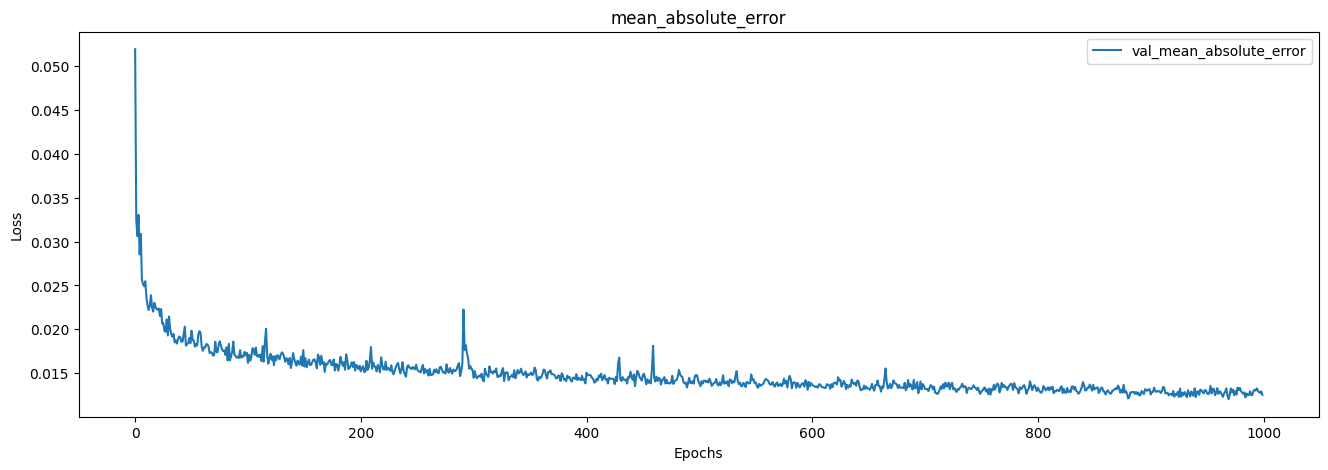

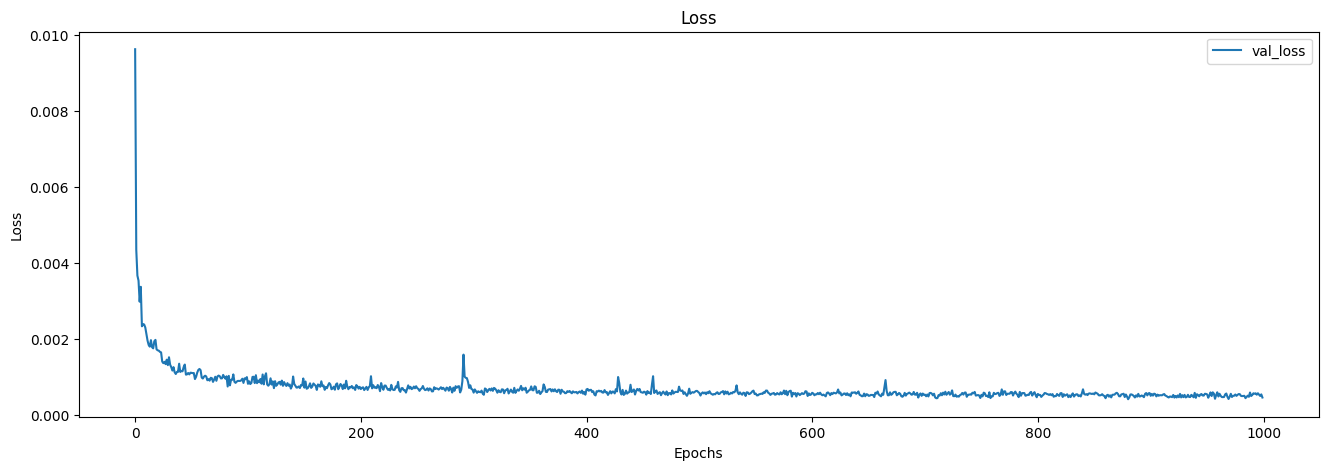

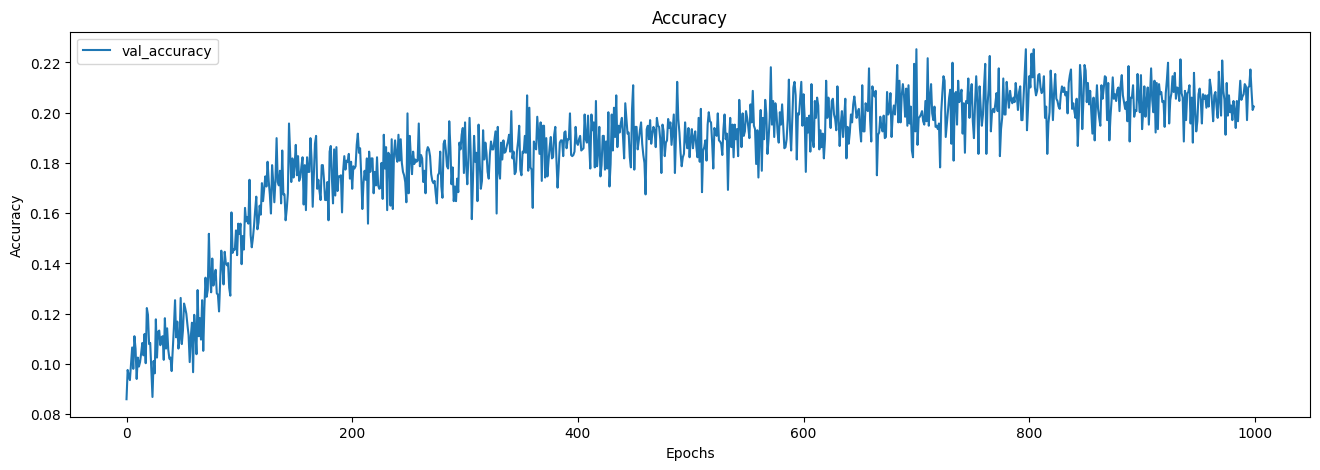

In [37]:
visualize_training_results(history)


In [38]:
# Evaluate the model on the test set
mse, accuracy, mae = model.evaluate(X_test_new, y_test_new)


17/17 [==============================] - 4s 34ms/step - loss: 0.0286 - accuracy: 0.1593 - mean_absolute_error: 0.1320


In [24]:
# Assuming X_test has shape (num_samples, num_features)
y_pred = model.predict(X_test_new)

# Reshape y_pred to have shape (num_samples, 1)
y_pred = y_pred.reshape(-1, 1)

# Create a new array with shape (num_samples, 10) to hold the predicted prices for the next 10 days
future_prices = np.zeros((y_pred.shape[0], 10))

# Use a for loop to predict the prices for the next 10 days
for i in range(10):
    # Get the most recent 7 days of data from y_pred
    past_data = y_pred[:, -7:]

    print(past_data.shape)
    print(past_data.size)
    # Reshape the data to have shape (num_samples, 7, 1) to feed it into the model
    past_data = past_data.reshape(past_data.shape[0], 1 ,7 )
    # Use the model to predict the price for the next day
    next_price = model.predict(past_data)
    # Add the predicted price to the future_prices array
    future_prices[:, i] = next_price.flatten()
    # Update y_pred with the predicted price for the next day
    y_pred = np.hstack([y_pred, next_price])
    
# Reshape future_prices to have shape (num_samples, 10)
future_prices = future_prices.reshape(-1, 10)


19/19 [==============================] - 0s 10ms/step
(597, 1)
597


ValueError: cannot reshape array of size 597 into shape (597,1,7)

In [39]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test_new)
print('y_pred', y_pred.shape)
print('y_test', y_test_new.shape)

# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test_new)


# evaluat
mse = mean_squared_error(y_test_new, y_pred)
mae = mean_absolute_error(y_test_new, y_pred)
mape = 100 * np.mean(np.abs((y_test_new - y_pred) / y_test_new))
rmse = np.sqrt(mean_squared_error(y_test_new, y_pred))


print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


17/17 [==============================] - 4s 33ms/step
y_pred (540, 10)
y_test (540, 10)
MAPE: 24.7298%
RMSE: 8762.2238
MSE: 76776565.9138
MAE:6835.8255


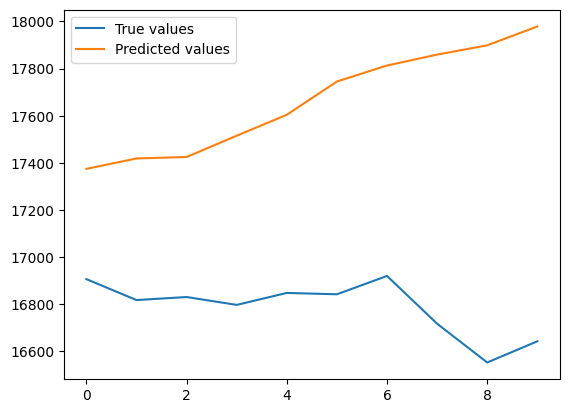

In [44]:
# Plot the true values and predicted values
plt.plot(y_test_new[-1], label='True values')
plt.plot(y_pred[-1], label='Predicted values')

# Add a legend and show the plot
plt.legend()
plt.show()


In [45]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=prediction_dates, end=today, freq='D')
test_dates = pd.date_range(start=test, end=today, freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


ValueError: Shape of passed values is (540, 10), indices imply (540, 1)

In [46]:
y_test_new


array([[35867.77734, 35040.83594, 33572.11719, ..., 34235.19531,
        33855.32813, 32877.37109],
       [35040.83594, 33572.11719, 33897.04688, ..., 33855.32813,
        32877.37109, 33798.01172],
       [33572.11719, 33897.04688, 34668.54688, ..., 32877.37109,
        33798.01172, 33520.51953],
       ...,
       [16757.97656, 16439.67969, 16906.30469, ..., 16841.98633,
        16919.80469, 16717.17383],
       [16439.67969, 16906.30469, 16817.53516, ..., 16919.80469,
        16717.17383, 16552.57227],
       [16906.30469, 16817.53516, 16830.3418 , ..., 16717.17383,
        16552.57227, 16642.3418 ]])

In [28]:
y_pred_df


,Adj Close
Date,
2021-07-06,34737.496094
2021-07-07,35216.570312
2021-07-08,35116.191406
2021-07-09,33564.878906
2021-07-10,34123.195312
...,...
2023-02-18,23873.218750
2023-02-19,24114.896484
2023-02-20,24164.734375


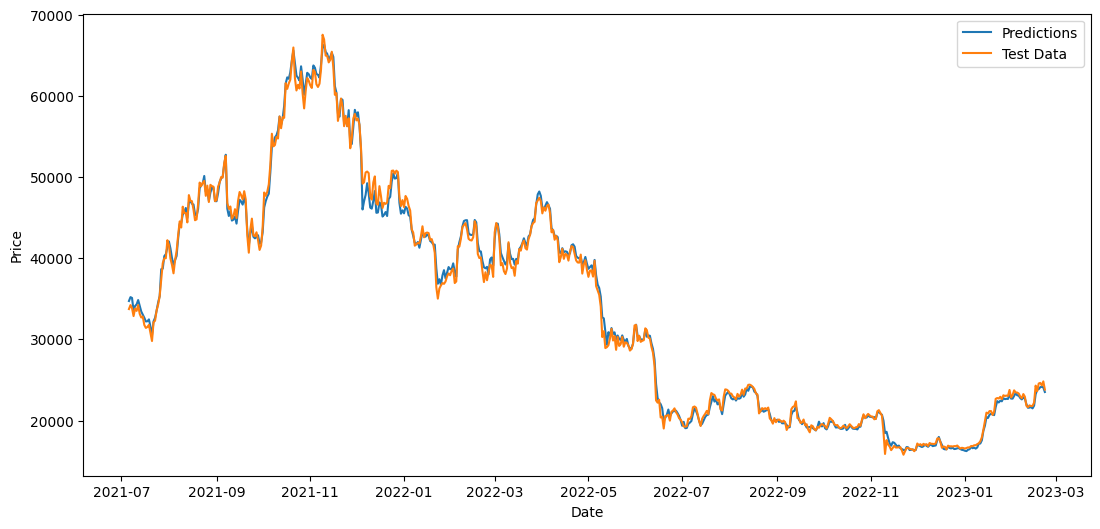

In [29]:
plt.figure(figsize=(13, 6))
plt.plot(y_pred_df['Adj Close'], label='Predictions')
plt.plot(y_test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [30]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [31]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))


mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')


MAPE: 1.6211%


In [32]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))


smape: 1.6155%


In [33]:
data2 = yf.download(tickers='BTC-usd', period='max', interval='1d')
data2


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-17,23621.283203,24924.041016,23460.755859,24565.601562,24565.601562,41358451255
2023-02-18,24565.296875,24798.835938,24468.373047,24641.277344,24641.277344,19625427158
2023-02-19,24640.027344,25093.054688,24327.642578,24327.642578,24327.642578,25555105670


In [34]:
# Step 2: Feature engineering
data2['RSI']       = ta.rsi(data2.Close, length=15)
data2['EMA_short'] = ta.ema(data2.Close, length=20)
data2['EMA_long']  = ta.ema(data2.Close, length=100)
data2.dropna(inplace=True)
data2.reset_index(inplace=True)
data2.drop(['Close'], axis=1, inplace=True)
# Setting the index
data2.set_index('Date', inplace=True)

# Dropping any NaNs
data2.dropna(inplace=True)

data2.info()
data2.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2981 entries, 2014-12-25 to 2023-02-22
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2981 non-null   float64
 1   High       2981 non-null   float64
 2   Low        2981 non-null   float64
 3   Adj Close  2981 non-null   float64
 4   Volume     2981 non-null   int64  
 5   RSI        2981 non-null   float64
 6   EMA_short  2981 non-null   float64
 7   EMA_long   2981 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 209.6 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,17821046406,48.538550,22317.339823,20103.186881
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,23918742607,48.750732,22268.840941,20136.947568
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,26792596581,53.052268,22264.266059,20178.212065
2023-02-15,22220.585938,24307.841797,22082.769531,24307.841797,32483312909,67.728410,22458.892320,20259.986911
2023-02-16,24307.349609,25134.117188,23602.523438,23623.474609,39316664596,61.025952,22569.804919,20326.590628
2023-02-17,23621.283203,24924.041016,23460.755859,24565.601562,41358451255,65.990173,22759.880790,20410.531439
2023-02-18,24565.296875,24798.835938,24468.373047,24641.277344,19625427158,66.358943,22939.061414,20494.308585
2023-02-19,24640.027344,25093.054688,24327.642578,24327.642578,25555105670,63.310636,23071.307239,20570.216189
2023-02-20,24336.623047,25020.458984,23927.910156,24829.148438,28987376573,65.987423,23238.720687,20654.551481


In [35]:
future_data = data.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume", "RSI",
                                                 "EMA_short", "EMA_long"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today, periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 7)
y_future_data: (30, 1)
x_future_data: (30, 7)
future_data_temp (30, 7)
future_data_temp (29, 7)
future_data_temp (28, 7)
future_data_temp (27, 7)
future_data_temp (26, 7)
future_data_temp (25, 7)
future_data_temp (24, 7)
future_data_temp (23, 7)
future_data_temp (22, 7)
future_data_temp (21, 7)


In [36]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 7)
1/1 [==============================] - 0s 63ms/step
future_data_temp2 (30, 1, 7)
---------------------------------------------------
future_data_temp1 (29, 7)
1/1 [==============================] - 0s 81ms/step
future_data_temp2 (29, 1, 7)
---------------------------------------------------
future_data_temp1 (28, 7)
1/1 [==============================] - 0s 50ms/step
future_data_temp2 (28, 1, 7)
---------------------------------------------------
future_data_temp1 (27, 7)
1/1 [==============================] - 0s 68ms/step
future_data_temp2 (27, 1, 7)
---------------------------------------------------
future_data_temp1 (26, 7)
1/1 [==============================] - 0s 45ms/step
future_data_temp2 (26, 1, 7)
---------------------------------------------------
future_data_temp1 (25, 7)
1/1 [==============================] - 0s 63ms/step
future_data_temp2 (25, 1, 7)
---------------------------------------------------
future_data_temp1 (24, 7)
1/1 [===============

In [37]:
prediction_df


,Adj Close
2023-02-23,22624.479197
2023-02-24,22579.312880
2023-02-25,22953.464504
2023-02-26,22898.359716
2023-02-27,22954.300421
2023-02-28,23013.474172
2023-03-01,23468.721956
2023-03-02,23057.002278
2023-03-03,23092.297558
2023-03-04,23396.177134


In [38]:
y_future_data


,Adj Close
Date,
2023-01-25,22934.431641
2023-01-26,22636.468750
2023-01-27,23117.859375
2023-01-28,23032.777344
2023-01-29,23078.728516
2023-01-30,23031.089844
2023-01-31,23774.566406
2023-02-01,22840.138672
2023-02-02,23139.283203


In [39]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [40]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [41]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [33]:
# Get the last date in the data
last_date = data.index[-1]

# Generate the next 30 days of dates
prediction_dates = pd.date_range(last_date, periods=30, freq='D')[1:]

# Get the most recent sequence of prices from the test data
last_sequence = X_test[-1]

# Reshape the sequence to (1, n_timesteps, n_features)
print('last_sequence', last_sequence.shape)
# last_sequence = last_sequence.reshape((1, last_sequence.shape[1], 1))
last_sequence = np.reshape(
    last_sequence, (1, last_sequence.shape[0], last_sequence.shape[1]))
# Use the model to predict the next 30 days of prices

predicted_prices = model.predict(last_sequence)


# Extract the first element of the predicted prices
next_price = predicted_prices[0][0]

# Create an array of zeros with a shape of (29, 1)
zeros_array = np.zeros((29, 1))

# Concatenate the next price with the zeros array
predicted_prices = np.concatenate((np.array([[next_price]]), zeros_array))

# Inverse transform the predicted prices
predicted_prices = scaler.inverse_transform(predicted_prices)

# Create a range of 30 days starting from the day after the last day in the training data
# prediction_dates = pd.date_range(last_date + pd.DateOffset(days=1), periods=30, freq='D')

# Create a DataFrame of the predicted prices

predicted_prices = pd.DataFrame(predicted_prices, columns=[
                                'Adj Close'], index=pd.date_range(last_date, periods=30, freq='D'))


last_sequence (1, 7)
1/1 [==============================] - 0s 101ms/step


In [34]:
predicted_prices


,Adj Close
2023-02-17,21238.22310
2023-02-18,20688.78125
2023-02-19,20688.78125
2023-02-20,20688.78125
2023-02-21,20688.78125
2023-02-22,20688.78125
2023-02-23,20688.78125
2023-02-24,20688.78125
2023-02-25,20688.78125
2023-02-26,20688.78125


In [35]:
# Step 7: Plot the predicted values
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(
    x=data.index, y=data['Adj Close'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=predicted_prices.index,
              y=predicted_prices['Adj Close'], mode='lines', name='Predicted'))
fig.update_layout(title='Bitcoin Price Predictions',
                  xaxis_title='Date', yaxis_title='Price (USD)')
fig.show()


In [36]:
# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = X_test[-30:]
print("last_five_days", last_five_days.shape)
last_five_days = np.reshape(
    last_five_days, (last_five_days.shape[0], 1, last_five_days.shape[2]))
predictions = []
for i in range(10):
    prediction = model.predict(last_five_days)[0]
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:, 1:, :],  [
                               prediction[np.newaxis, :]], axis=1)


last_five_days (30, 1, 7)
1/1 [==============================] - 0s 84ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 30 and the array at index 1 has size 1

In [50]:
# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = np.array(X_test[-30:])
predictions = []
for i in range(10):
    """""
    print(f"last_five_days.shape={last_five_days.shape}")
    prediction = model.predict(last_five_days)[0]
    print(f"prediction.shape={prediction.shape}")
    #prediction = np.squeeze(prediction, axis=0)
    #print(f"prediction.shape={prediction.shape}")
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:,1:,:], [prediction[np.newaxis,:]], axis=1)"""

    prediction = model.predict(last_five_days)
    print(f"prediction.shape1={prediction.shape}")
    prediction = np.reshape(prediction, (prediction.shape[0], 1))
    print(f"prediction.shape2={prediction.shape}")
    predictions.append(prediction)
    prediction = np.expand_dims(prediction, axis=1)
    last_five_days = np.append(last_five_days[:, 1:, :], prediction, axis=1)


1/1 [==============================] - 0s 223ms/step
prediction.shape1=(30, 1)
prediction.shape2=(30, 1)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 1 has size 1

In [51]:
# Initialize empty list to store predictions
predictions = []

# Iterate over test data
for i in range(len(X_test) - 1):

    # Get the last 5 days of data
    last_five_days = X_test[i:i+1]

    # Reshape last_five_days to match input shape of the model
    last_five_days = np.reshape(last_five_days, (1, 1, 7))

    # Make a prediction
    prediction = model.predict(last_five_days)

    # Append prediction to list of predictions
    predictions.append(prediction)

    # Reshape prediction to match output shape of model
    prediction = np.reshape(prediction, (1, 1, 1))

    # Append prediction to last_five_days
    last_five_days = np.append(last_five_days[:, 1:, :], prediction, axis=1)


1/1 [==============================] - 0s 116ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 1 has size 1

In [66]:
# Generate predictions
predictions = []
for i in range(len(X_test)):
    X_test = last_five_days.reshape((1, 1, 7))
    prediction = model.predict(X_test, verbose=1)
    predictions.append(prediction)
    prediction = np.reshape(prediction, (1, 1, 1))
    print('1- prediction     :', prediction.shape)
    print('2- last_five_days :', last_five_days.shape)
    last_five_days = np.append(last_five_days[:, 1:, :], prediction, axis=2)

# Convert predictions to array and reshape
predictions = np.array(predictions).reshape(-1, 1)


1/1 [==============================] - 0s 102ms/step
1- prediction     : (1, 1, 1)
2- last_five_days : (1, 1, 7)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 1